# CS 184A/284A: Detect Sleep States - Child Mind Institute

# 1. Setup

In [1]:
import sys
print(sys.executable)

!pip list

/Users/chenhanlyu/miniconda3/bin/python
Package                   Version
------------------------- ------------
accelerate                0.25.0
aiohttp                   3.9.1
aiosignal                 1.3.1
anyio                     3.5.0
appnope                   0.1.2
archspec                  0.2.1
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asttokens                 2.0.5
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.11.0
backcall                  0.2.0
beautifulsoup4            4.12.2
bleach                    4.1.0
boltons                   23.0.0
Bottleneck                1.3.5
Brotli                    1.0.9
causal-learn              0.1.3.6
certifi                   2023.11.17
cffi                      1.16.0
cfgv                      3.4.0
charset-normalizer        2.0.4
clarabel                  0.6.0
click                     8.1.7
comm                      0.1.2
conda                     23.10.0
conda-

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools

import torch
import torch.nn as nn

from torch import tensor
from torch.utils.data import Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, zero_one_loss


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device

'mps'

In [30]:
train = pd.read_parquet("train_series.parquet")
train.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [31]:
train.size

639731700

In [32]:
train_event = pd.read_csv("train_events.csv")
train_event.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [33]:
train_event.size

72540

In [34]:
test = pd.read_parquet("test_series.parquet")
test.size

2250

# 2. Data Exploration

### Features

*   **anglez**: Sleep angle (X-Z plane)
*   **enmo**: "Euclidean norm minus one" from accelerometer data
*   **timestamp**

### Output
*   **event**:



In [35]:
series_ids = train_event['series_id'].unique()
series_ids.size

277

277 series

ebd76e93ec7d Anglez plot


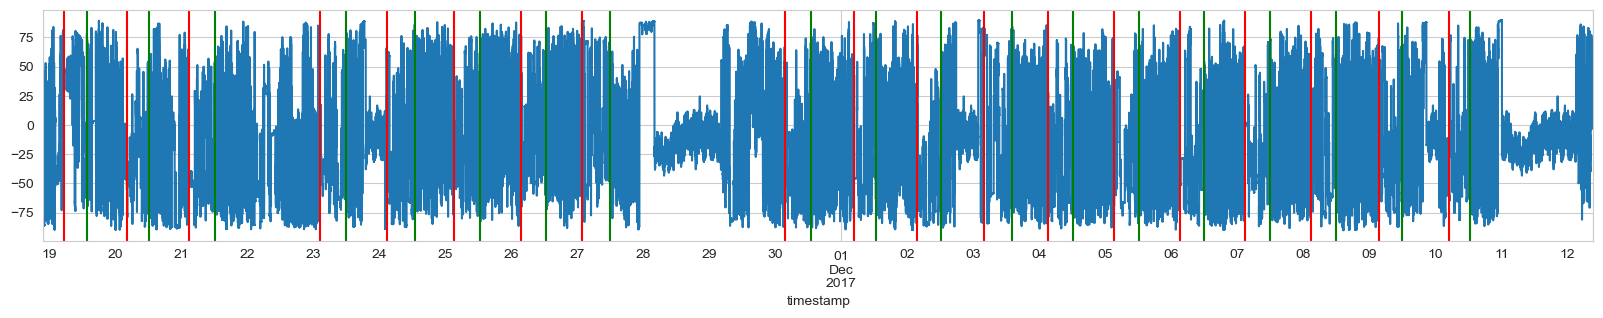

ebd76e93ec7d enmo plot


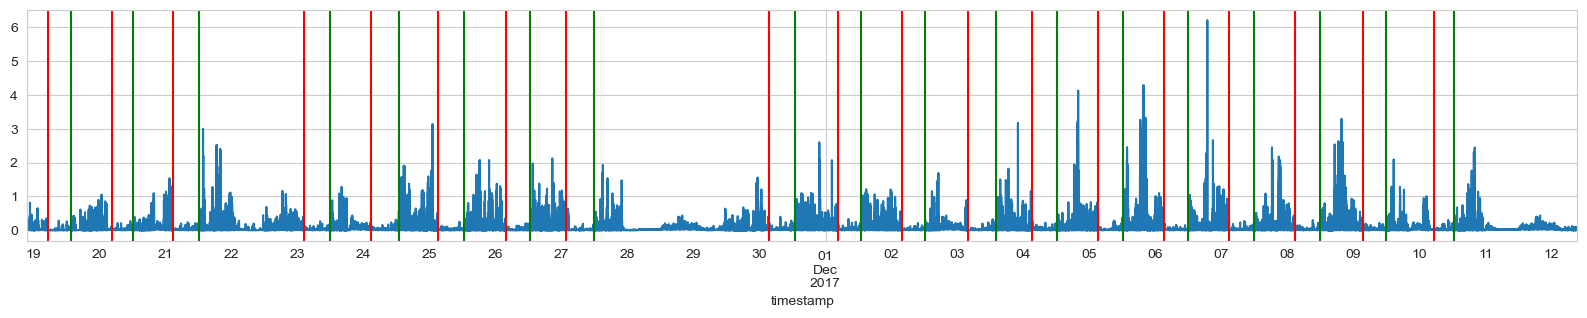

e0d7b0dcf9f3 Anglez plot


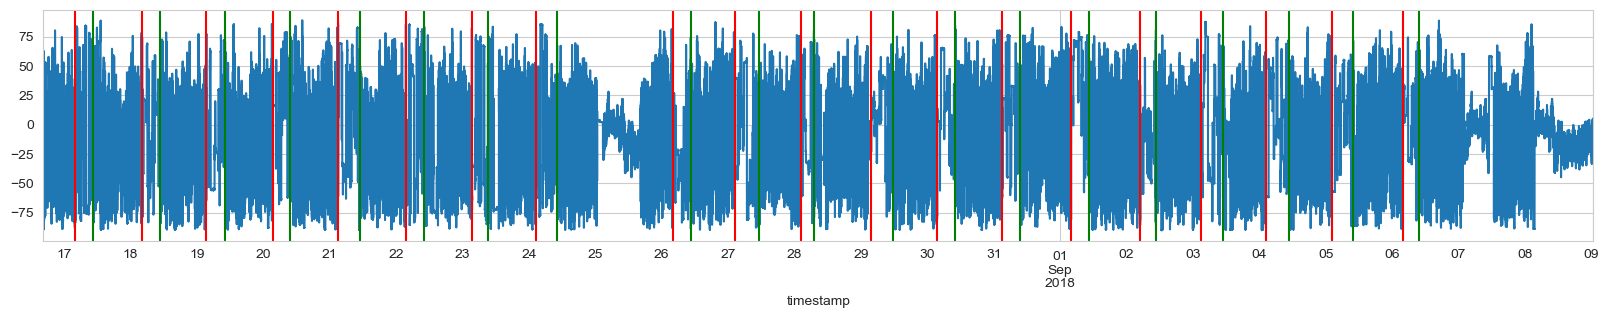

e0d7b0dcf9f3 enmo plot


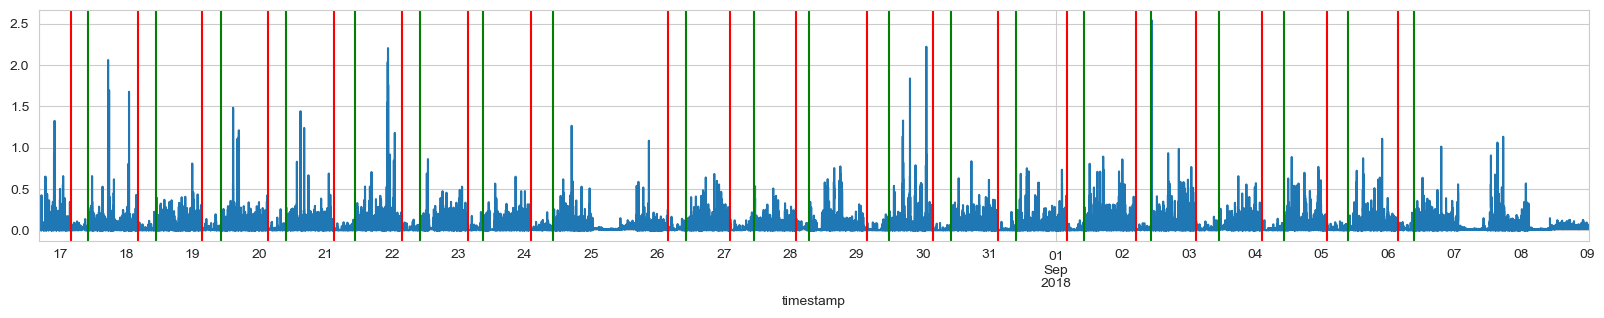

12d01911d509 Anglez plot


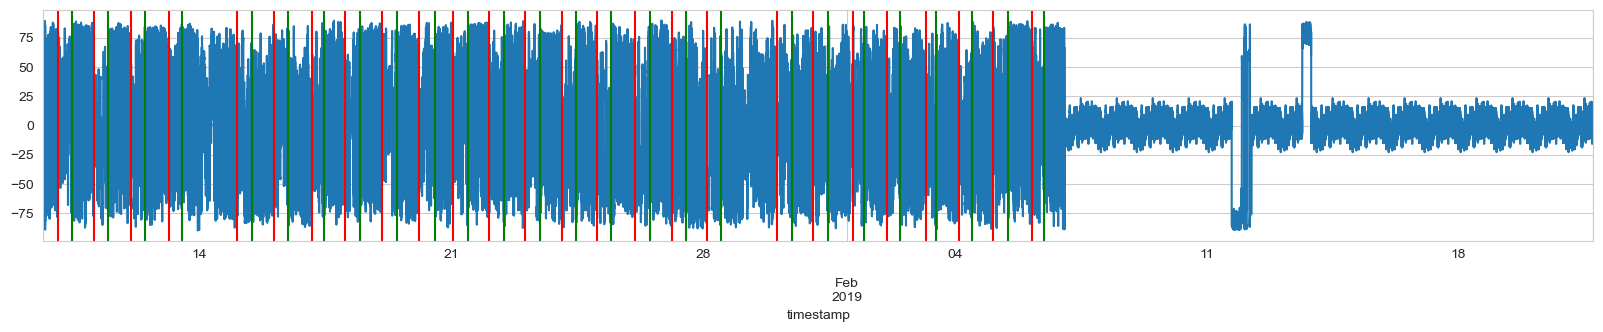

12d01911d509 enmo plot


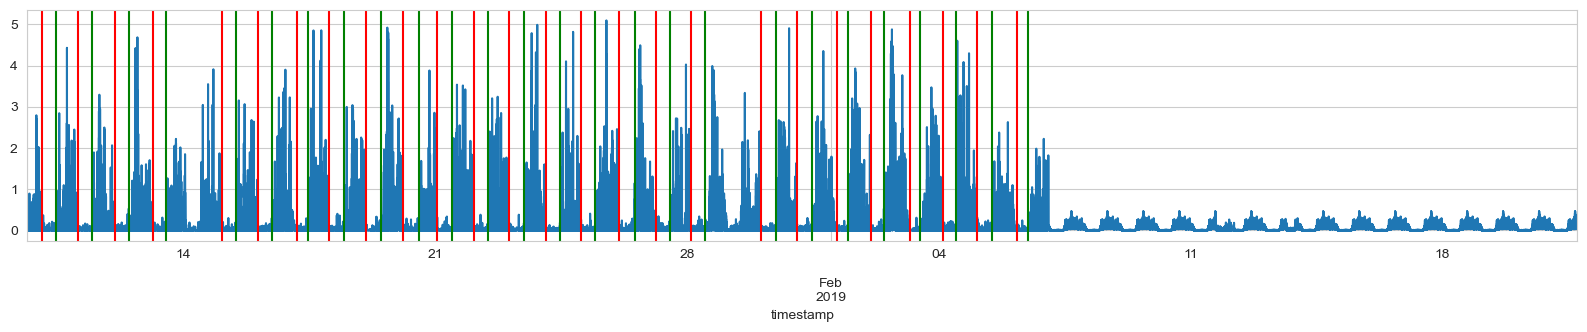

In [36]:
for i in range (3):
    id = series_ids[random.choice(range(277))]
    train_id = train[train["series_id"] == id]
    train_id_event = train_event[train_event["series_id"] == id]
    index_nan = train_id_event.isnull().any(axis = 1)
    non_nan_event = train_id_event[~index_nan]

    non_nan_event.index = pd.to_datetime(non_nan_event['timestamp'], utc=True)
    train_id.index = pd.to_datetime(train_id['timestamp'], utc=True)


    print(id, "Anglez plot")
    fig, ax = plt.subplots(figsize=(20, 3))
    train_id['anglez'].plot(ax=ax)
    for _time, _event in zip(non_nan_event.index, non_nan_event['event']):
        ax.axvline(x=_time, color='red' if _event=='onset' else 'green')
    plt.show()

    print(id, "enmo plot")
    fig, ax = plt.subplots(figsize=(20, 3))
    train_id['enmo'].plot(ax=ax)
    for _time, _event in zip(non_nan_event.index, non_nan_event['event']):
        ax.axvline(x=_time, color='red' if _event=='onset' else 'green')
    plt.show();

Could find that between each state, the enmo data and anglez will have certain relation with sleep states. Also some discovery of missing data in the event, which stated by the document: cannot determine whether the event happened or not.

# 3. Preprocessing

Model building in ZZZ datasets

In [3]:
series_ids = ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a']
multi_series = pd.read_parquet("Zzzs_train.parquet", filters=[('series_id','in',series_ids)])

multi_series.head()

multi_series.shape

(2844900, 6)

Add features for timestamp, hour, and anglez*enmo product

In [4]:
def process(multi_series):
  multi_series["timestamp"] = pd.to_datetime(multi_series["timestamp"],utc=True)
  multi_series["hour"] = multi_series["timestamp"].dt.hour
  multi_series["anglez_times_enmo"] = multi_series["anglez"] * multi_series["enmo"]
  multi_series["anglez_max"] = multi_series.groupby("series_id")["anglez"].transform('max')
  multi_series["anglez_min"] = multi_series.groupby("series_id")["anglez"].transform('min')
  multi_series["enmo_max"] = multi_series.groupby("series_id")["enmo"].transform('max')
  return multi_series

multi_series = process(multi_series)
multi_series.head()


,series_id,step,timestamp,anglez,enmo,awake,hour,anglez_times_enmo,anglez_max,anglez_min,enmo_max
0,08db4255286f,0,2018-11-05 14:00:00+00:00,-30.845301,0.0447,1,14,-1.378785,89.286697,-89.976898,2.9656
1,08db4255286f,1,2018-11-05 14:00:05+00:00,-34.181801,0.0443,1,14,-1.514254,89.286697,-89.976898,2.9656
2,08db4255286f,2,2018-11-05 14:00:10+00:00,-33.877102,0.0483,1,14,-1.636264,89.286697,-89.976898,2.9656
3,08db4255286f,3,2018-11-05 14:00:15+00:00,-34.282101,0.0680,1,14,-2.331183,89.286697,-89.976898,2.9656
4,08db4255286f,4,2018-11-05 14:00:20+00:00,-34.385799,0.0768,1,14,-2.640830,89.286697,-89.976898,2.9656


### Standardize features

In [5]:
scaler = StandardScaler()
df_train_X_scaled = scaler.fit_transform(multi_series[["step", "hour","anglez","enmo","anglez_times_enmo", "anglez_max", "anglez_min", "enmo_max"]])

df_train_y = multi_series["awake"]

/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

In [84]:
Xtr, Xva, ytr, yva = train_test_split(df_train_X_scaled, df_train_y)

Xtr = tensor(Xtr, dtype=torch.float32).to(device)
Xva = tensor(Xva, dtype=torch.float32).to(device)
# print(ytr, yva)
ytr = tensor(ytr.values, dtype=torch.float32).to(device)
yva = tensor(yva.values, dtype=torch.float32).to(device)
Xtr.shape, Xva.shape, ytr.shape, yva.shape


(torch.Size([2133675, 8]),
 torch.Size([711225, 8]),
 torch.Size([2133675]),
 torch.Size([711225]))

In [7]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        super(MyDataset, self).__init__()
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = MyDataset(Xtr, ytr)
valid_dataset = MyDataset(Xva, yva)

batch_size = 288  #tried 50, 100, 300

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [47]:
print('Train data: ', len(train_dataset))
print('Valid data: ', len(valid_dataset))

Train data:  2133675
Valid data:  711225


# 3.MLP

In [73]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.001
BATCH_SIZE = 288

INPUT_SIZE = 8
HIDDEN_SIZE = 512


In [74]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.linear2(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [75]:
model = MLP(INPUT_SIZE,HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()
for epoch in range(NUM_EPOCHS):
    for i, (Xtr, ytr) in enumerate(train_loader):
        # Forward pass
        output = model(Xtr)

        ytr = ytr.unsqueeze(-1)
        # print(output, ytr)
        loss = criterion(output, ytr)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, NUM_EPOCHS, i+1, len(train_loader), loss.item()))

Epoch [1/3], Step [100/7409], Loss: 0.6345
Epoch [1/3], Step [200/7409], Loss: 0.5911
Epoch [1/3], Step [300/7409], Loss: 0.5584
Epoch [1/3], Step [400/7409], Loss: 0.5372
Epoch [1/3], Step [500/7409], Loss: 0.5474
Epoch [1/3], Step [600/7409], Loss: 0.5376
Epoch [1/3], Step [700/7409], Loss: 0.5020
Epoch [1/3], Step [800/7409], Loss: 0.5000
Epoch [1/3], Step [900/7409], Loss: 0.4732
Epoch [1/3], Step [1000/7409], Loss: 0.4930
Epoch [1/3], Step [1100/7409], Loss: 0.5230
Epoch [1/3], Step [1200/7409], Loss: 0.5120
Epoch [1/3], Step [1300/7409], Loss: 0.4859
Epoch [1/3], Step [1400/7409], Loss: 0.4765
Epoch [1/3], Step [1500/7409], Loss: 0.4502
Epoch [1/3], Step [1600/7409], Loss: 0.4927
Epoch [1/3], Step [1700/7409], Loss: 0.4710
Epoch [1/3], Step [1800/7409], Loss: 0.4611
Epoch [1/3], Step [1900/7409], Loss: 0.4811
Epoch [1/3], Step [2000/7409], Loss: 0.4524
Epoch [1/3], Step [2100/7409], Loss: 0.4390
Epoch [1/3], Step [2200/7409], Loss: 0.4725
Epoch [1/3], Step [2300/7409], Loss: 0.44

In [76]:
y_pred = []
y_target = []

model.eval()

with torch.no_grad():
     for i, (X_train, y_valid) in enumerate(valid_loader):
        output = model(X_train).cpu()
        y_pred_tag = (output>0.5).int()
        y_pred.append(y_pred_tag.detach().numpy())
        y_target.append(y_valid.cpu().detach().numpy())

y_pred = [a.squeeze().tolist() for a in y_pred]
y_pred = list(itertools.chain.from_iterable(y_pred))
y_target = [a.squeeze().tolist() for a in y_target]
y_target = list(itertools.chain.from_iterable(y_target))
zero_one_loss(y_target, y_pred)

0.18906112692889032

In [77]:
torch.save(model.state_dict(), "MLP.model")

# 4. LSTM Model

In [50]:
# hyperparameters
NUM_EPOCHS = 20    #3, 5, 9, 20
LEARNING_RATE = 0.001
BATCH_SIZE = 288

INPUT_SIZE = 8
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, 128, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.lstm2(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

### Training

In [11]:
model = LSTMModel(INPUT_SIZE,HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()
for epoch in range(NUM_EPOCHS):
    for i, (Xtr, ytr) in enumerate(train_loader):
        # Forward pass
        output = model(Xtr)

        ytr = ytr.unsqueeze(-1)
        # print(output, ytr)
        loss = criterion(output, ytr)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, NUM_EPOCHS, i+1, len(train_loader), loss.item()))

Epoch [1/20], Step [100/7409], Loss: 0.3778
Epoch [1/20], Step [200/7409], Loss: 0.3061
Epoch [1/20], Step [300/7409], Loss: 0.2070
Epoch [1/20], Step [400/7409], Loss: 0.1879
Epoch [1/20], Step [500/7409], Loss: 0.2781
Epoch [1/20], Step [600/7409], Loss: 0.2290
Epoch [1/20], Step [700/7409], Loss: 0.1968
Epoch [1/20], Step [800/7409], Loss: 0.2057
Epoch [1/20], Step [900/7409], Loss: 0.1412
Epoch [1/20], Step [1000/7409], Loss: 0.1629
Epoch [1/20], Step [1100/7409], Loss: 0.1329
Epoch [1/20], Step [1200/7409], Loss: 0.1887
Epoch [1/20], Step [1300/7409], Loss: 0.1525
Epoch [1/20], Step [1400/7409], Loss: 0.1801
Epoch [1/20], Step [1500/7409], Loss: 0.1921
Epoch [1/20], Step [1600/7409], Loss: 0.1331
Epoch [1/20], Step [1700/7409], Loss: 0.1663
Epoch [1/20], Step [1800/7409], Loss: 0.1334
Epoch [1/20], Step [1900/7409], Loss: 0.1469
Epoch [1/20], Step [2000/7409], Loss: 0.1048
Epoch [1/20], Step [2100/7409], Loss: 0.1712
Epoch [1/20], Step [2200/7409], Loss: 0.1402
Epoch [1/20], Step 

In [14]:
torch.save(model.state_dict(), "LSTM.model")

### Evaluation

In [69]:
y_pred = []
y_target = []

model.eval()

with torch.no_grad():
     for i, (X_train, y_valid) in enumerate(valid_loader):
        output = model(X_train).cpu()
        y_pred_tag = (output>0.5).int()
        y_pred.append(y_pred_tag.detach().numpy())
        y_target.append(y_valid.cpu().detach().numpy())

y_pred = [a.squeeze().tolist() for a in y_pred]
y_pred = list(itertools.chain.from_iterable(y_pred))
y_target = [a.squeeze().tolist() for a in y_target]
y_target = list(itertools.chain.from_iterable(y_target))

In [70]:
print(y_target)
print(y_pred)

from sklearn.metrics import zero_one_loss

zero_one_loss(y_target, y_pred)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



0.011498470948012263

In [71]:
one_test_point = multi_series[multi_series['series_id'] == '29c75c018220']
one_test_point.head()
scaler = StandardScaler()
one_test_point__X_scaled = scaler.fit_transform(one_test_point[["step", "hour","anglez","enmo","anglez_times_enmo", "anglez_max", "anglez_min", "enmo_max"]])
Xte = tensor(one_test_point__X_scaled, dtype=torch.float32).to(device)
output = model(Xte).cpu()
y_pred_tag = (output>0.5).int()

/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

In [72]:
one_test_point['predict'] = y_pred_tag

/var/folders/ym/yml1d6wx7kv8q3bpyg4bgtrm0000gn/T/ipykernel_12090/2582398223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_test_point['predict'] = y_pred_tag


In [73]:
one_test_point.head()

,series_id,step,timestamp,anglez,enmo,awake,hour,anglez_times_enmo,anglez_max,anglez_min,enmo_max,predict
2380680,29c75c018220,0,2018-04-04 16:30:00+00:00,6.6186,0.0029,1,16,0.019194,89.356003,-90.0,5.8975,1
2380681,29c75c018220,1,2018-04-04 16:30:05+00:00,5.3420,0.0068,1,16,0.036326,89.356003,-90.0,5.8975,1
2380682,29c75c018220,2,2018-04-04 16:30:10+00:00,10.1475,0.0113,1,16,0.114667,89.356003,-90.0,5.8975,1
2380683,29c75c018220,3,2018-04-04 16:30:15+00:00,11.7255,0.0042,1,16,0.049247,89.356003,-90.0,5.8975,1
2380684,29c75c018220,4,2018-04-04 16:30:20+00:00,9.0151,0.0077,1,16,0.069416,89.356003,-90.0,5.8975,1


/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

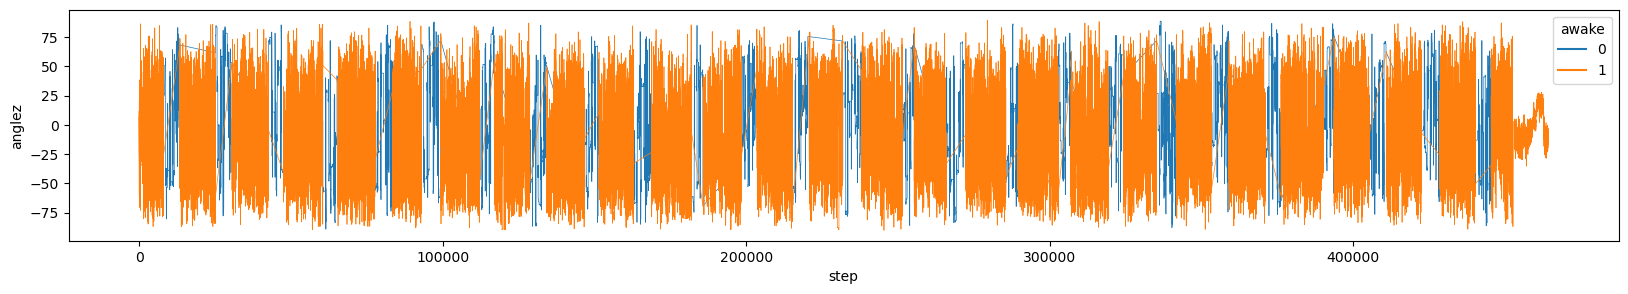

/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

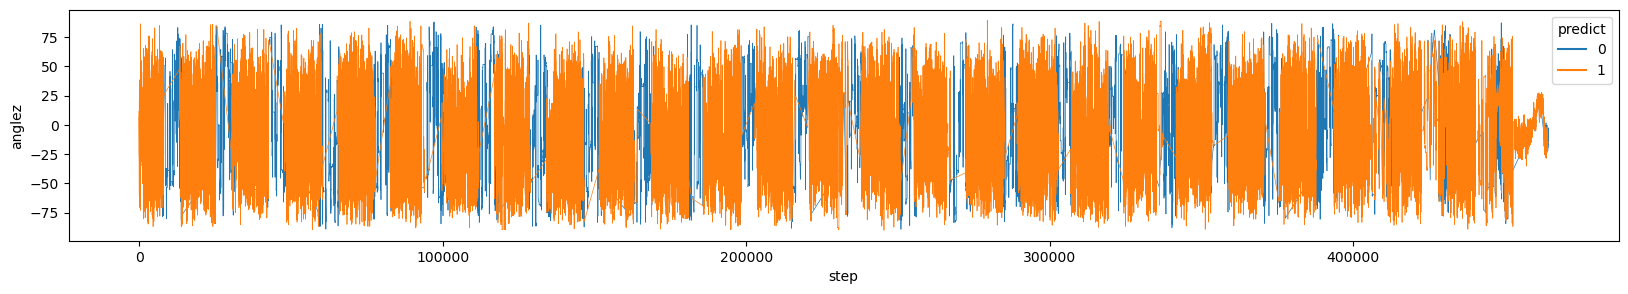

In [75]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=one_test_point, x="step", y="anglez",hue="awake", linewidth = 0.5)
plt.show();
    
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=one_test_point, x="step", y="anglez",hue="predict", linewidth = 0.5)
plt.show();

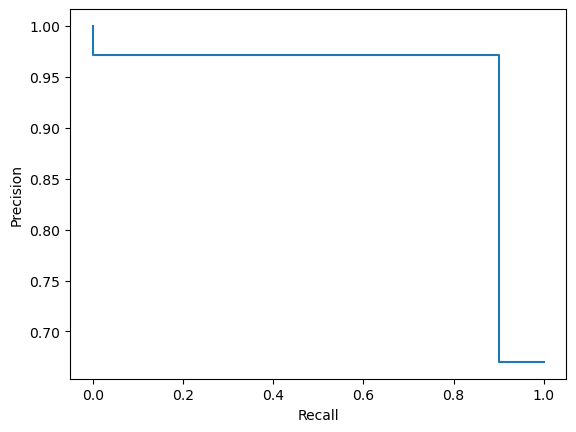

In [23]:
precision, recall, _ = precision_recall_curve(y_target, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

# 5. RNN Model

In [55]:
NUM_EPOCHS = 5  #[5,7,9] #need to choose 5
LEARNING_RATE = 0.001  #need to choose 0.001[0.1, 0.01, 0.001]
BATCH_SIZE = 288 

INPUT_SIZE = 8
HIDDEN_SIZE = 128 
NUM_LAYERS = 2  #need to choose 2 [1,2], 3 takes too long to train
OUTPUT_SIZE = 1

In [51]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected (linear) layer for output
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Forward pass through the RNN layer
        out, _ = self.rnn(x, None)
        # Get the output from the last time step
        # Pass the output through the fully connected layer
        out = self.fc(out)
        return out

In [56]:
 lr_tester = []
 for lr in LEARNING_RATE:
    model = RNN(INPUT_SIZE, HIDDEN_SIZE, 1 ,OUTPUT_SIZE).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(NUM_EPOCHS):
        for i, (Xtr, ytr) in enumerate(train_loader):
            # Forward pass
            output = model(Xtr)
    
            ytr = ytr.unsqueeze(-1)
            # print(output, ytr)
            loss = criterion(output, ytr)
    
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, NUM_EPOCHS, i+1, len(train_loader), loss.item()))
    lr_tester.append(model)

Epoch [1/5], Step [100/7409], Loss: 0.4889
Epoch [1/5], Step [200/7409], Loss: 0.4244
Epoch [1/5], Step [300/7409], Loss: 0.4363
Epoch [1/5], Step [400/7409], Loss: 0.4785
Epoch [1/5], Step [500/7409], Loss: 0.3725
Epoch [1/5], Step [600/7409], Loss: 0.4034
Epoch [1/5], Step [700/7409], Loss: 0.4239
Epoch [1/5], Step [800/7409], Loss: 0.3741
Epoch [1/5], Step [900/7409], Loss: 0.4656
Epoch [1/5], Step [1000/7409], Loss: 0.7392
Epoch [1/5], Step [1100/7409], Loss: 0.6345
Epoch [1/5], Step [1200/7409], Loss: 0.5361
Epoch [1/5], Step [1300/7409], Loss: 0.5947
Epoch [1/5], Step [1400/7409], Loss: 0.6106
Epoch [1/5], Step [1500/7409], Loss: 0.5361
Epoch [1/5], Step [1600/7409], Loss: 0.6835
Epoch [1/5], Step [1700/7409], Loss: 0.6007
Epoch [1/5], Step [1800/7409], Loss: 0.5970
Epoch [1/5], Step [1900/7409], Loss: 0.5670
Epoch [1/5], Step [2000/7409], Loss: 0.6229
Epoch [1/5], Step [2100/7409], Loss: 0.6143
Epoch [1/5], Step [2200/7409], Loss: 0.5172
Epoch [1/5], Step [2300/7409], Loss: 0.68

In [62]:
for i in range(len(lr_tester)):
    y_pred = []
    y_target = []
    model = lr_tester[i]
    model.eval()
    with torch.no_grad():
         for i, (X_train, y_valid) in enumerate(valid_loader):
            output = model(X_train).cpu()
            y_pred_tag = (output>0.5).int()
            y_pred.append(y_pred_tag.detach().numpy())
            y_target.append(y_valid.cpu().detach().numpy())
    
    y_pred = [a.squeeze().tolist() for a in y_pred]
    y_pred = list(itertools.chain.from_iterable(y_pred))
    y_target = [a.squeeze().tolist() for a in y_target]
    y_target = list(itertools.chain.from_iterable(y_target))
    print(zero_one_loss(y_target, y_pred))

0.353589932862315
0.06828921930472076
0.06566135892298497


In [9]:
#without feature engineering

scaler = StandardScaler()
df_train_X_scaled = scaler.fit_transform(multi_series[["step","anglez","enmo"]])

df_train_y = multi_series["awake"]
Xtr, Xva, ytr, yva = train_test_split(df_train_X_scaled, df_train_y)

Xtr = tensor(Xtr, dtype=torch.float32).to(device)
Xva = tensor(Xva, dtype=torch.float32).to(device)
print(Xtr.shape)
ytr = tensor(ytr.values, dtype=torch.float32).to(device)
yva = tensor(yva.values, dtype=torch.float32).to(device)

train_dataset = MyDataset(Xtr, ytr)
valid_dataset = MyDataset(Xva, yva)

batch_size = 288  #tried 50, 100, 300

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

NUM_EPOCHS = 3    #3, 5, 9, 20
LEARNING_RATE = 0.001
BATCH_SIZE = 288

INPUT_SIZE = 3
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.lstm2(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = LSTMModel(INPUT_SIZE,HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()
for epoch in range(NUM_EPOCHS):
    for i, (Xtr, ytr) in enumerate(train_loader):
        # Forward pass
        output = model(Xtr)

        ytr = ytr.unsqueeze(-1)
        # print(output, ytr)
        loss = criterion(output, ytr)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, NUM_EPOCHS, i+1, len(train_loader), loss.item()))
y_pred = []
y_target = []

model.eval()

with torch.no_grad():
    for i, (X_train, y_valid) in enumerate(valid_loader):
        output = model(X_train).cpu()
        y_pred_tag = (output > 0.5).int()
        y_pred.append(y_pred_tag.detach().numpy())
        y_target.append(y_valid.cpu().detach().numpy())

y_pred = [a.squeeze().tolist() for a in y_pred]
y_pred = list(itertools.chain.from_iterable(y_pred))
y_target = [a.squeeze().tolist() for a in y_target]
y_target = list(itertools.chain.from_iterable(y_target))
print(y_target)
print(y_pred)

from sklearn.metrics import zero_one_loss

zero_one_loss(y_target, y_pred)

/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/chenhanlyu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

torch.Size([2133675, 3])
Epoch [1/3], Step [100/7409], Loss: 0.6366
Epoch [1/3], Step [200/7409], Loss: 0.5528
Epoch [1/3], Step [300/7409], Loss: 0.4460
Epoch [1/3], Step [400/7409], Loss: 0.4648
Epoch [1/3], Step [500/7409], Loss: 0.4234
Epoch [1/3], Step [600/7409], Loss: 0.4604
Epoch [1/3], Step [700/7409], Loss: 0.4541
Epoch [1/3], Step [800/7409], Loss: 0.4525
Epoch [1/3], Step [900/7409], Loss: 0.4470
Epoch [1/3], Step [1000/7409], Loss: 0.5362
Epoch [1/3], Step [1100/7409], Loss: 0.4408
Epoch [1/3], Step [1200/7409], Loss: 0.4243
Epoch [1/3], Step [1300/7409], Loss: 0.4759
Epoch [1/3], Step [1400/7409], Loss: 0.4713
Epoch [1/3], Step [1500/7409], Loss: 0.4079
Epoch [1/3], Step [1600/7409], Loss: 0.4225
Epoch [1/3], Step [1700/7409], Loss: 0.5125
Epoch [1/3], Step [1800/7409], Loss: 0.4619
Epoch [1/3], Step [1900/7409], Loss: 0.4184
Epoch [1/3], Step [2000/7409], Loss: 0.4400
Epoch [1/3], Step [2100/7409], Loss: 0.4272
Epoch [1/3], Step [2200/7409], Loss: 0.4415
Epoch [1/3], Ste

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



0.20383422967415377